# ZK lending
This notebook illustrate the idea of ZK lending.

some introduction to be added


## Setup

install and import necessary libraries

In [3]:
!pip install tenseal

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 8.0 MB/s eta 0:00:00


In [88]:
import torch
import tenseal as ts
import pandas as pd
import random
from time import time

# those are optional and are not necessary for training
import numpy as np
import matplotlib.pyplot as plt

We use the dataset for credit score classification from [kaggle](https://www.kaggle.com/datasets/parisrohan/credit-score-classification/data?select=train.csv).

We already clean the data and for the purpose of clarity, we won't show the cleaning process here. You can check the data cleaning part in our code base


In [90]:
torch.random.manual_seed(73)
random.seed(73)


def split_train_test(x, y, test_ratio=0.3):
    idxs = [i for i in range(len(x))]
    random.shuffle(idxs)
    # delimiter between test and train data
    delim = int(len(x) * test_ratio)
    test_idxs, train_idxs = idxs[:delim], idxs[delim:]
    return x[train_idxs], y[train_idxs], x[test_idxs], y[test_idxs]


# def heart_disease_data():
#     data = pd.read_csv("./data/framingham.csv")
#     # drop rows with missing values
#     data = data.dropna()
#     # drop some features
#     data = data.drop(columns=["education", "currentSmoker", "BPMeds", "diabetes", "diaBP", "BMI"])
#     # balance data
#     grouped = data.groupby('TenYearCHD')
#     data = grouped.apply(lambda x: x.sample(grouped.size().min(), random_state=73).reset_index(drop=True))
#     # extract labels
#     y = torch.tensor(data["TenYearCHD"].values).float().unsqueeze(1)
#     data = data.drop("TenYearCHD", 'columns')
#     # standardize data
#     data = (data - data.mean()) / data.std()
#     x = torch.tensor(data.values).float()
#     return split_train_test(x, y)


def random_data(m=100, n=10):
    # data separable by the line `y = x`
    x_train = torch.randn(m, n)
    x_test = torch.randn(m // 2, n)
    y_train = (x_train[:, 0] >= x_train[:, 1]).float().unsqueeze(0).t()
    y_test = (x_test[:, 0] >= x_test[:, 1]).float().unsqueeze(0).t()
    return x_train, y_train, x_test, y_test


# You can use whatever data you want without modification to the tutorial
# x_train, y_train, x_test, y_test = random_data()
x_train, y_train, x_test, y_test = random_data()

print("############# Data summary #############")
print(f"x_train has shape: {x_train.shape}")
print(f"y_train has shape: {y_train.shape}")
print(f"x_test has shape: {x_test.shape}")
print(f"y_test has shape: {y_test.shape}")
print("#######################################")

############# Data summary #############
x_train has shape: torch.Size([100, 10])
y_train has shape: torch.Size([100, 1])
x_test has shape: torch.Size([50, 10])
y_test has shape: torch.Size([50, 1])
#######################################


We saw that evaluating on the encrypted test set doesn't affect the accuracy that much. I've even seen examples where the encrypted evaluation performs better.

## Training an Encrypted Logistic Regression Model on Encrypted Data

In this part we will redefine a PyTorch-like model that can both forward encrypted data, as well as backpropagate to update the weights and thus train the encrypted logistic regression model on encrypted data. Below are more details about the training.

#### Loss Function

We are using the binary cross entropy loss function with regularization (more about the why of regularization will follow) where $y^{(i)}$ is the i'th expected label, $\hat{y}^{(i)}$ is the i'th output of the logistic regression model and $\theta$ is our n-sized weight vector.

$$Loss(\theta) = - \frac{1}{m} \sum_{i=1}^m [y^{(i)} log(\hat{y}^{(i)}) + (1 - y^{(i)}) log (1 - \hat{y}^{(i)})] + \frac{\lambda}{2m} \sum_{j=1}^n \theta_j^2$$

#### Parameters Update

For updating the parameter, the usual rule is as follows, where $x^{(i)}$ is the i'th input data:

$$\theta_j = \theta_j - \alpha \; [ \frac{1}{m} \sum_{i=1}^m (\hat{y}^{(i)} - y^{(i)}) x^{(i)} + \frac{\lambda}{m} \theta_j]$$

However, due to homomorphic encryption constraint, we preferred to use an $\alpha = 1$ to reduce a multiplication and set $\frac{\lambda}{m} = 0.05$ which gets us to the following update rule:

$$\theta_j = \theta_j - [ \frac{1}{m} \sum_{i=1}^m (\hat{y}^{(i)} - y^{(i)}) x^{(i)} + 0.05 \theta_j]$$

#### Sigmoid Approximation

Since we can't simply compute sigmoid on encrypted data, we need to approximate it using a low degree polynomial, the lower the degree the better, as we aim to perform as few multiplications as possible, to be able to use smaller parameters and thus optimize computation. This tutorial uses a degree 3 polynomial from https://eprint.iacr.org/2018/462.pdf, which approximates the sigmoid function in the range $[-5,5]$.

$$\sigma(x) = 0.5 + 0.197 x - 0.004 x^3$$

#### Homomorphic Encryption Parameters

From the input data to the parameter update, a ciphertext will need a multiplicative depth of 6, 1 for the dot product operation, 2 for the sigmoid approximation, and 3 for the backpropagation phase (one is actually hidden in the `self._delta_w += enc_x * out_minus_y` operation in the `backward()` function, which is multiplying a 1-sized vector with an n-sized one, which requires masking the first slot and replicating it n times in the first vector). With a scale of around 20 bits, we need 6 coefficients modulus with the same bit-size as the scale, plus the last coefficient, which needs more bits, we are already out of the 4096 polynomial modulus degree (which requires < 109 total bit count of the coefficients modulus, if we consider 128-bit security), so we will use 8192. This will allow us to batch up to 4096 values in a single ciphertext, but we are far away from this limitation, so we shouldn't even think about it.


In [81]:
class EncryptedLR:

    def __init__(self, n_features):
        model = torch.nn.Linear(n_features, 1)
        self.weight = model.weight.data.tolist()[0]
        self.bias = model.bias.data.tolist()
        # we accumulate gradients and counts the number of iterations
        self._delta_w = 0
        self._delta_b = 0
        self._count = 0

    def forward(self, enc_x):
        enc_out = enc_x.dot(self.weight) + self.bias
        enc_out = EncryptedLR.sigmoid(enc_out)
        return enc_out

    def backward(self, enc_x, enc_out, enc_y):
        out_minus_y = (enc_out - enc_y)
        self._delta_w += enc_x * out_minus_y
        self._delta_b += out_minus_y
        self._count += 1

    def update_parameters(self):
        if self._count == 0:
            raise RuntimeError("You should at least run one forward iteration")
        # update weights
        # We use a small regularization term to keep the output
        # of the linear layer in the range of the sigmoid approximation
        self.weight -= self._delta_w * (1 / self._count) + self.weight * 0.05
        self.bias -= self._delta_b * (1 / self._count)
        # reset gradient accumulators and iterations count
        self._delta_w = 0
        self._delta_b = 0
        self._count = 0

    @staticmethod
    def sigmoid(enc_x):
        # We use the polynomial approximation of degree 3
        # sigmoid(x) = 0.5 + 0.197 * x - 0.004 * x^3
        # from https://eprint.iacr.org/2018/462.pdf
        # which fits the function pretty well in the range [-5,5]
        return enc_x.polyval([0.5, 0.197, 0, -0.004])

    def plain_accuracy(self, x_test, y_test):
        # evaluate accuracy of the model on
        # the plain (x_test, y_test) dataset
        w = torch.tensor(self.weight)
        b = torch.tensor(self.bias)
        out = torch.sigmoid(x_test.matmul(w) + b).reshape(-1, 1)
        correct = torch.abs(y_test - out) < 0.5
        return correct.float().mean()

    def encrypt(self, context):
        self.weight = ts.ckks_vector(context, self.weight)
        self.bias = ts.ckks_vector(context, self.bias)

    def decrypt(self):
        self.weight = self.weight.decrypt()
        self.bias = self.bias.decrypt()

    def __call__(self, *args, **kwargs):
        return self.forward(*args, **kwargs)


In [91]:
# parameters
poly_mod_degree = 8192
coeff_mod_bit_sizes = [40, 21, 21, 21, 21, 21, 21, 40]
# create TenSEALContext
ctx_training = ts.context(ts.SCHEME_TYPE.CKKS, poly_mod_degree, -1, coeff_mod_bit_sizes)
ctx_training.global_scale = 2 ** 21
ctx_training.generate_galois_keys()

In [92]:
t_start = time()
enc_x_train = [ts.ckks_vector(ctx_training, x.tolist()) for x in x_train]
enc_y_train = [ts.ckks_vector(ctx_training, y.tolist()) for y in y_train]
t_end = time()
print(f"Encryption of the training_set took {int(t_end - t_start)} seconds")

Encryption of the training_set took 2 seconds


Below we study the distribution of `x.dot(weight) + bias` in both plain and encrypted domains. Making sure that it falls into the range $[-5,5]$, which is where our sigmoid approximation is good at, and we don't want to feed it data that is out of this range so that we don't get erroneous output, which can make our training behave unpredictably. But the weights will change during the training process, and we should try to keep them as small as possible while still learning. A technique often used with logistic regression, and we do exactly this (but serving another purpose which is *generalization*), is known as *regularization*, and you might already have spotted the additional term `self.weight * 0.05` in the `update_parameters()` function, which is the result of doing regularization.

To recap, since our sigmoid approximation is only good in the range $[-5,5]$, we want to have all its inputs in that range. In order to do this, we need to keep our logistic regression parameters as small as possible, so we apply regularization.

**Note:** Keeping the parameters small certainly reduces the magnitude of the output, but we can also get out of range if the data wasn't standardized. You may have spotted that we standardized the data with a mean of 0 and std of 1, this was both for better performance, as well as to keep the inputs to the sigmoid in the desired range.

Distribution on encrypted data:


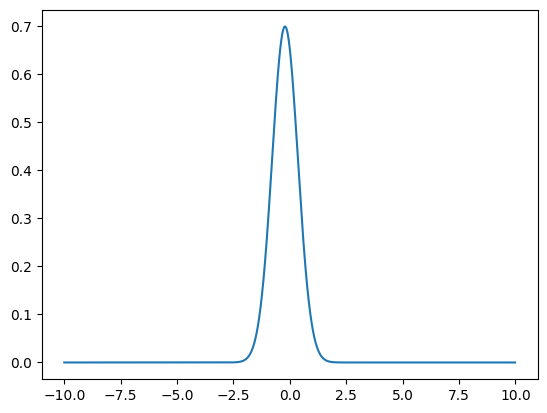

In [93]:
normal_dist = lambda x, mean, var: np.exp(- np.square(x - mean) / (2 * var)) / np.sqrt(2 * np.pi * var)

def plot_normal_dist(mean, var, rmin=-10, rmax=10):
    x = np.arange(rmin, rmax, 0.01)
    y = normal_dist(x, mean, var)
    fig = plt.plot(x, y)

# plain distribution
# lr = LR(n_features)
# data = lr.lr(x_test)
# mean, var = map(float, [data.mean(), data.std() ** 2])
# plot_normal_dist(mean, var)
# print("Distribution on plain data:")
# plt.show()

#encrypted distribution
def encrypted_out_distribution(encrypted_logistic, enc_x_test):
    w = encrypted_logistic.weight
    b = encrypted_logistic.bias
    data = []
    for enc_x in enc_x_test:
        enc_out = enc_x.dot(w) + b
        data.append(enc_out.decrypt())
    data = torch.tensor(data)
    mean, var = map(float, [data.mean(), data.std() ** 2])
    plot_normal_dist(mean, var)
    print("Distribution on encrypted data:")
    plt.show()

n_features = x_train.shape[1]

encrypted_logistic = EncryptedLR(n_features)
encrypted_logistic.encrypt(ctx_training)
encrypted_out_distribution(encrypted_logistic, enc_x_train)

Most of the data falls into $[-5,5]$, the sigmoid approximation should be good enough!

We finally reached the last part, which is about training an encrypted logistic regression model on encrypted data! You can see that we decrypt the weights and re-encrypt them again after every epoch, this is necessary since after updating the weights at the end of the epoch, we can no longer use them to perform enough multiplications, so we need to get them back to the initial ciphertext level. In a real scenario, this would translate to sending the weights back to the secret-key holder for decryption and re-encryption. In that case, it will result in just a few Kilobytes of communication per epoch.

In [95]:
encrypted_logistic = EncryptedLR(n_features)
# accuracy = eelr.plain_accuracy(x_test, y_test)
# print(f"Accuracy at epoch #0 is {accuracy}")

times = []

## temp
EPOCHS=1

for epoch in range(EPOCHS):
    encrypted_logistic.encrypt(ctx_training)

    # if you want to keep an eye on the distribution to make sure
    # the function approximation is still working fine
    # WARNING: this operation is time consuming
    # encrypted_out_distribution(eelr, enc_x_train)

    t_start = time()
    for enc_x, enc_y in zip(enc_x_train, enc_y_train):
        enc_out = encrypted_logistic.forward(enc_x)
        encrypted_logistic.backward(enc_x, enc_out, enc_y)
    encrypted_logistic.update_parameters()
    t_end = time()
    times.append(t_end - t_start)

    encrypted_logistic.decrypt()
    accuracy = encrypted_logistic.plain_accuracy(x_test, y_test)
    print(f"Accuracy at epoch #{epoch + 1} is {accuracy}")


print(encrypted_logistic.weight)
print(encrypted_logistic.bias)


# print(f"\nAverage time per epoch: {int(sum(times) / len(times))} seconds")
# print(f"Final accuracy is {accuracy}")

# diff_accuracy = plain_accuracy - accuracy
# print(f"Difference between plain and encrypted accuracies: {diff_accuracy}")
# if diff_accuracy < 0:
#     print("Oh! We got a better accuracy when training on encrypted data! The noise was on our side...")


Accuracy at epoch #1 is 0.9399999976158142
[1.015377036120562, -1.1959251731381393, -0.15128247212029075, -0.10031845901031751, -0.04793443171365424, -0.01023744801326075, 0.14224718184126958, -0.4667343890129133, 0.1015768257033605, 0.059186276666773854]
[0.24503304160099715]


## Comparision with plain Logistic Regression Model
Now let's train a plain logistic regression model with pytorch and compare the result with model trained with homomorphic encryption

In [97]:
class LogisticModel(torch.nn.Module):

    def __init__(self, n_features):
        super(LogisticModel, self).__init__()
        self.linear = torch.nn.Linear(n_features, 1)

    def forward(self, x):
        out = torch.sigmoid(self.linear(x))
        return out

# defining model, optimizer and loss function
n_features = x_train.shape[1]
plain_logistic = LogisticModel(n_features)
optim = torch.optim.SGD(plain_logistic.parameters(), lr=1)
lossf = torch.nn.BCELoss()

EPOCHS =5

# training process
for epoch in range(EPOCHS):
    optim.zero_grad()
    out = plain_logistic(x_train)
    loss = lossf(out, y_train)
    loss.backward()
    optim.step()
    print(f"Loss at epoch {epoch + 1}: {loss.data}")


# print(plain_logistic.linear.weight)
# print(plain_logistic.linear.bias)

# calculate the accuracy
def accuracy(model, x, y):
    out = model(x)
    correct = torch.abs(y - out) < 0.5
    return correct.float().mean()

plain_accuracy = accuracy(plain_logistic, x_test, y_test)
print(f"Accuracy of plain model on test_set: {plain_accuracy}")

print(plain_logistic.linear.weight)

print(plain_logistic.linear.bias)




Loss at epoch 1: 0.725821852684021
Loss at epoch 2: 0.49990516901016235
Loss at epoch 3: 0.3958192467689514
Loss at epoch 4: 0.33897164463996887
Loss at epoch 5: 0.3026331067085266
Accuracy of plain model on test_set: 0.9399999976158142
Parameter containing:
tensor([[ 1.0065, -0.9780, -0.0405,  0.0571,  0.1674, -0.0064, -0.0295, -0.4292,
          0.0449,  0.1444]], requires_grad=True)
Parameter containing:
tensor([-0.0667], requires_grad=True)


# Convert encrypted model to ONNX format and thus can be feed into EZKL

Now we do a conversion, unfortunately there is no elegant way to do so, as tenseal does not natively support exporting to ONNX format. So we have to convert it first to a pytorch logistic model, by manually assigned it's weight and bias to what we just trained in encrypted model, and then export it using pytorch's api


In [105]:
model_to_EZKL = LogisticModel(n_features)
print(model_to_EZKL.linear.weight)
print(model_to_EZKL.linear.bias)
model_to_EZKL.linear.weight.data = torch.tensor([encrypted_logistic.weight])
model_to_EZKL.linear.bias.data = torch.tensor(encrypted_logistic.bias)

print(model_to_EZKL.linear.weight)
print(model_to_EZKL.linear.bias)

print(plain_logistic.linear.weight)
print(plain_logistic.linear.bias)

test_accuracy = accuracy(model_to_EZKL, x_test, y_test)
print(f"Accuracy of plain to ezkl on test_set: {test_accuracy}")



Parameter containing:
tensor([[-0.0004, -0.1120,  0.0045, -0.2022,  0.0072, -0.0397,  0.2048, -0.1929,
          0.3028, -0.1658]], requires_grad=True)
Parameter containing:
tensor([0.1143], requires_grad=True)
Parameter containing:
tensor([[ 1.0154, -1.1959, -0.1513, -0.1003, -0.0479, -0.0102,  0.1422, -0.4667,
          0.1016,  0.0592]], requires_grad=True)
Parameter containing:
tensor([0.2450], requires_grad=True)
Parameter containing:
tensor([[ 1.0065, -0.9780, -0.0405,  0.0571,  0.1674, -0.0064, -0.0295, -0.4292,
          0.0449,  0.1444]], requires_grad=True)
Parameter containing:
tensor([-0.0667], requires_grad=True)
Accuracy of plain to ezkl on test_set: 0.9399999976158142
